In [291]:
from langgraph.graph import StateGraph, START, END
from pygments.lexer import words
from typing_extensions import TypedDict
from langgraph.types import CachePolicy
from langgraph.cache.memory import InMemoryCache
from datetime import datetime
from typing import Annotated
from langgraph.types import Send

In [292]:
import operator


def update_function(old, new):
    return old + new


class InputState(TypedDict):
    hello: Annotated[list[str], update_function]

class State(TypedDict):
    words : list[str]
    output: Annotated[list[dict[str, int]], operator.add]

graph_builder = StateGraph(State)


In [293]:
def node_one(state: State) -> State:
    return state


def node_two(word : str) -> State:
    return {
        "output" : [
            {
                "word" : word,
                "output" : len(word)
            }
        ]
    }


In [294]:
graph_builder.add_node("node_one", node_one)
graph_builder.add_node("node_two", node_two)

def dispatcher(state: State):
    return [Send("node_two", word) for word in state["words"]]

graph_builder.add_edge(START, "node_one")
graph_builder.add_conditional_edges("node_one", dispatcher, ["node_two"])
graph_builder.add_edge("node_two", END)


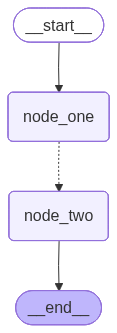

result: {'words': ['hello', 'world', 'how', 'are', 'you', 'doing'], 'output': [{'word': 'hello', 'output': 5}, {'word': 'world', 'output': 5}, {'word': 'how', 'output': 3}, {'word': 'are', 'output': 3}, {'word': 'you', 'output': 3}, {'word': 'doing', 'output': 5}]}


In [295]:
graph = graph_builder.compile(cache=InMemoryCache())
display(graph)
# print(graph.get_graph().draw_ascii())


import time

result = graph.invoke({
    "words": ["hello", "world", "how", "are", "you", "doing"],
})
print("result:", result)